In [1]:
import simpy
import random
import pyray as pr
import matplotlib.pyplot as plt
import numpy as np

RAYLIB STATIC 5.5.0.4 LOADED


In [ ]:
#Simulation Parameters
AGENT_COUNT = 5
CUSTOMER_WAIT_MEAN = 1.2
SERVICE_TIME = [5, 10]
CALLBACK_PROB = 0.3 
QUEUE_THRESHOLD = 3
CALLBACK_DELAY = 10 


SIM_TIME = 200 # Total sim time for graphs
simulation_speed = 0.01 # Time speed for the animation

#To Change the simulation's randomness
random.seed(22)

In [ ]:
#Simulation Class
class CallCenterSim:
    def __init__(self, env, agent_count):
        self.env = env
        self.agents = simpy.Resource(env, agent_count)
        self.active_callbacks = 0
        self.data = []
        
        #LOGGING LISTS FOR GRAPHS
        #(time, value)
        self.log_queue_len = [(0, 0)]   # Q(t) data
        self.log_busy_agents = [(0, 0)] # B(t) data

    #Saving state for graphs
    def log_state(self):
        self.log_queue_len.append((self.env.now, len(self.agents.queue)))
        self.log_busy_agents.append((self.env.now, self.agents.count))

    def caller_arrival(self):
        i = 0
        while True:
            yield self.env.timeout(random.expovariate(1.0 / CUSTOMER_WAIT_MEAN))
            i += 1
            self.env.process(self.handle_call(f"Customer {i}"))

    def handle_call(self, name):
        arrival_time = self.env.now
        call_type = 'NORMAL'
        
        self.log_state()

        #Decision: Callback 
        if (len(self.agents.queue) > QUEUE_THRESHOLD) and (random.random() < CALLBACK_PROB):
            call_type = 'CALLBACK'
            self.log_state()
            self.env.process(self.handle_recall(name))
            return 
        
        #Join Queue
        with self.agents.request() as req:
            yield req 
            
            #Start Service
            call_start_time = self.env.now
            self.log_state()

            delay = call_start_time - arrival_time
            service_duration = random.uniform(SERVICE_TIME[0], SERVICE_TIME[1])
            
            yield self.env.timeout(service_duration)
            
            #End Service
            call_exit_time = self.env.now
            self.log_state()
            
            self.data.append({
                'id': name,
                'type': call_type,
                'wait_delay': delay,
                'total_system_time': call_exit_time - arrival_time,
                'duration': service_duration
            })

    def handle_recall(self, name):
        self.active_callbacks += 1
        yield self.env.timeout(CALLBACK_DELAY)
        self.active_callbacks -= 1
        self.env.process(self.handle_call(name))

In [ ]:
#Animation Functions
def draw_agents(sim, total_agents, start_x, start_y, size=100, gap=10):
    pr.draw_text("Agent Status:", start_x, start_y - 30, 20, pr.BLACK)

    for i in range(total_agents):
        if i < sim.agents.count:
            color = pr.RED
            status = "BUSY"
        else:
            color = pr.GREEN 
            status = "FREE"
        
        current_x = start_x + i * (size + gap)

        pr.draw_rectangle(current_x, start_y, size, size, color)
        pr.draw_rectangle_lines(current_x, start_y, size, size, pr.BLACK)
        pr.draw_text(f"Agent {i+1}\n{status}", current_x + 10, start_y + size // 2 - 20, 15, pr.BLACK)

def draw_queue(sim, start_x, start_y, radius =10, gap=5):
    count = len(sim.agents.queue)

    pr.draw_text("Queue:", start_x, start_y - 30, 20, pr.BLACK)
    for i in range(count):
        current_x = start_x + i * (2 * radius + gap)
        current_y = start_y
        pr.draw_circle(current_x + radius, current_y + radius, radius, pr.BLUE)
        pr.draw_circle_lines(current_x + radius, current_y + radius, radius, pr.BLACK)

def draw_callbacks(sim, start_x, start_y, radius=10, gap=5):
    count = sim.active_callbacks

    pr.draw_text("Active Callbacks:", start_x, start_y - 30, 20, pr.BLACK)
    for i in range(count):
        current_x = start_x + i * (2 * radius + gap)
        current_y = start_y
        pr.draw_circle(current_x + radius, current_y + radius, radius, pr.ORANGE)
        pr.draw_circle_lines(current_x + radius, current_y + radius, radius, pr.BLACK)

In [ ]:
#Main Animation Loop
def main():
    pr.init_window(800, 600, "Call Center Simulation")
    pr.set_target_fps(60)

    env = simpy.Environment()
    sim = CallCenterSim(env, AGENT_COUNT)
    env.process(sim.caller_arrival())
    while not pr.window_should_close():
        env.run(until=env.now + simulation_speed)

        pr.begin_drawing()
        pr.clear_background(pr.RAYWHITE)

        pr.draw_text(f"SimTime: {env.now:.2f}", 10, 10, 20, pr.BLACK)
        draw_agents(sim, AGENT_COUNT, 50, 100)

        draw_queue(sim,10,300,10,5)

        draw_callbacks(sim,10,450,10,5)

        pr.end_drawing()
    pr.close_window()

if __name__ == "__main__":
    main()

________________________________________
SIMULATION REPORT (T=200)
________________________________________
1. Avg Delay in Queue:      9.29 min
2. Service Level (<5min):   35.0%
3. Time-Avg Num in Queue:   8.35
4. Server Utilization:      93.49%
________________________________________


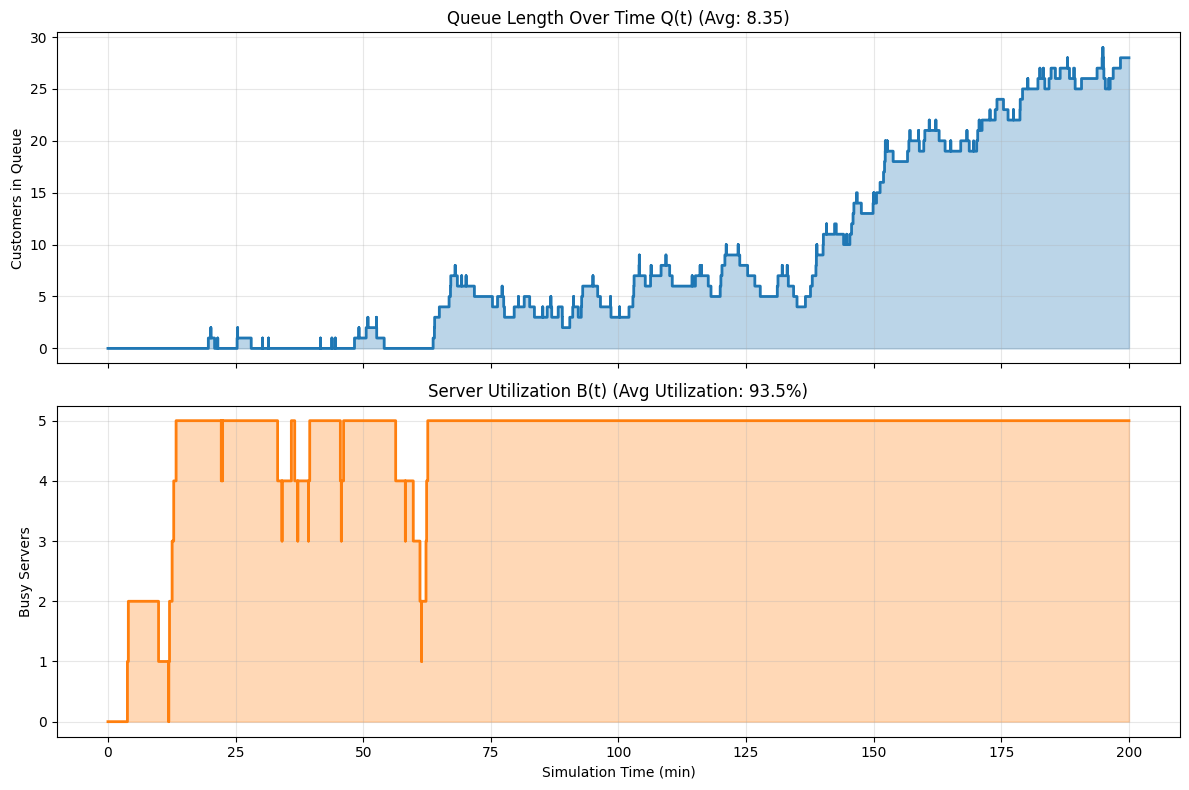

In [ ]:
#RUN SIMULATION
env = simpy.Environment()
sim = CallCenterSim(env, AGENT_COUNT)
env.process(sim.caller_arrival())
env.run(until=SIM_TIME)

#CALCULATING METRICS
#Average Delay & Service Level (Wait < 5 min)
delays = [d['wait_delay'] for d in sim.data]
avg_delay = np.mean(delays)

# Count how many were served in under 5 minutes (Service Level)
served_within_5 = sum(1 for d in delays if d < 5)
percent_within_5 = (served_within_5 / len(delays)) * 100

#Time-Weighted Averages
def get_time_weighted_avg(log_list, total_time):
    total_area = 0
    # Add end point to close the graph
    log_list.append((total_time, log_list[-1][1])) 
    
    for i in range(len(log_list) - 1):
        t_now, val = log_list[i]
        t_next, _ = log_list[i+1]
        duration = t_next - t_now
        total_area += val * duration
    return total_area / total_time

avg_num_in_queue = get_time_weighted_avg(sim.log_queue_len, SIM_TIME)
avg_busy_servers = get_time_weighted_avg(sim.log_busy_agents, SIM_TIME)
server_utilization = avg_busy_servers / AGENT_COUNT

#PRINT REPORT
print("_"*40)
print(f"SIMULATION REPORT (T={SIM_TIME})")
print("_"*40)
print(f"1. Avg Delay in Queue:      {avg_delay:.2f} min")
print(f"2. Service Level (<5min):   {percent_within_5:.1f}%")
print(f"3. Time-Avg Num in Queue:   {avg_num_in_queue:.2f}")
print(f"4. Server Utilization:      {server_utilization:.2%}")
print("_"*40)


#PLOT GRAPHS
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Graph 1: Q(t) - Queue Length
q_times, q_values = zip(*sim.log_queue_len)
ax1.step(q_times, q_values, where='post', color='tab:blue', linewidth=2)
ax1.fill_between(q_times, q_values, step='post', alpha=0.3, color='tab:blue')
ax1.set_title(f"Queue Length Over Time Q(t) (Avg: {avg_num_in_queue:.2f})")
ax1.set_ylabel("Customers in Queue")
ax1.grid(True, alpha=0.3)

# Graph 2: B(t) - Server Busy Status
b_times, b_values = zip(*sim.log_busy_agents)
ax2.step(b_times, b_values, where='post', color='tab:orange', linewidth=2)
ax2.fill_between(b_times, b_values, step='post', alpha=0.3, color='tab:orange')
ax2.set_title(f"Server Utilization B(t) (Avg Utilization: {server_utilization:.1%})")
ax2.set_ylabel("Busy Servers")
ax2.set_xlabel("Simulation Time (min)")
ax2.set_yticks(range(AGENT_COUNT + 1)) # Force integer ticks 0-5
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()